In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn Imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report

In [ ]:
# --- PLOTTING IMPORTS ---
# 1. Confusion Matrix
try:
    from sklearn.metrics import ConfusionMatrixDisplay
    CAN_PLOT_CM = True
    print("Successfully imported ConfusionMatrixDisplay.")
except ImportError as e:
    print(f"Could not import ConfusionMatrixDisplay or plot_confusion_matrix. Will skip CM plot. Error: {e}")

# 2. ROC-AUC Curve
try:
    from sklearn.metrics import RocCurveDisplay
    CAN_PLOT_ROC = True
    print("Successfully imported RocCurveDisplay.")
except ImportError as e:
    print(f"Could not import RocCurveDisplay or plot_roc_curve. Will skip ROC-AUC plot. Error: {e}")

# 3. Precision-Recall Curve (NEW)
try:
    from sklearn.metrics import PrecisionRecallDisplay
    CAN_PLOT_PR = True
    print("Successfully imported PrecisionRecallDisplay.")
except ImportError as e:
    print(f"Could not import PrecisionRecallDisplay. Will skip PR Curve plot. Error: {e}")

Successfully imported ConfusionMatrixDisplay.
Successfully imported RocCurveDisplay.
Successfully imported PrecisionRecallDisplay.


In [ ]:
# --- 0. LOAD DATA ---
df = pd.read_csv('post_clean_1.csv')
print("Successfully loaded in the dataset")
print(f"Original shape: {df.shape}")

print("\n0. Loading Data")
df1 = df.copy()

FileNotFoundError: [Errno 2] No such file or directory: 'post_clean_1.csv'

In [ ]:
df1.head()

,vehicle_type,pickup_location,drop_location,vehicle_arrival_time,ride_cost,distance,booking_timestamp,hour,day,month,...,customer_patience,historical_customer_avg_rating,historical_customer_rating_binned,weather_timestamp,temperature,humidity,precipitation_mm,weather_condition,pickup_zone,drop_zone
0,Bike,Udyog Vihar,Ambience Mall,10.8,99.0,37.98,2024-01-01 00:19:34,0,Monday,1,...,new_customer,NaN,No Prior Rating,2024-01-01 00:00:00,7.1,99,0.0,Clear,Gurgaon,Gurgaon
1,Go Mini,Basai Dhankot,Madipur,8.5,114.0,39.29,2024-01-01 01:35:18,1,Monday,1,...,new_customer,NaN,No Prior Rating,2024-01-01 01:00:00,6.9,100,0.0,Clear,Gurgaon,West Delhi
2,Go Mini,Jhilmil,Welcome,8.1,735.0,39.39,2024-01-01 01:53:01,1,Monday,1,...,new_customer,NaN,No Prior Rating,2024-01-01 01:00:00,6.9,100,0.0,Clear,East Delhi,East Delhi
3,Go Mini,Sarojini Nagar,Madipur,2.9,918.0,44.21,2024-01-01 03:59:29,3,Monday,1,...,new_customer,NaN,No Prior Rating,2024-01-01 03:00:00,6.0,100,0.0,Mainly Clear/Cloudy,South Delhi,West Delhi
4,eBike,Panchsheel Park,Pragati Maidan,8.6,423.0,40.82,2024-01-01 04:00:07,4,Monday,1,...,new_customer,NaN,No Prior Rating,2024-01-01 04:00:00,6.5,99,0.0,Mainly Clear/Cloudy,South Delhi,Central Delhi


In [ ]:
# --- 1. Define Features ---
print("\n--- 1. Defining Feature Groups ---")
target_col = 'is_cancelled'

# This time we are going for a pipelined approach unlike during our last presentation for a proper industry-standard
# as well as to prevent any data leakage

# Numerical features - will be scaled in preprocessor
numerical_cols = [
    'vehicle_arrival_time', 'distance', 'ride_cost',
    'temperature', 'humidity', 'precipitation_mm'
]

# Categorical features - will be One-Hot Encoded in preprocessor
categorical_cols = [
    'vehicle_type', 'customer_patience', 'pickup_zone', 'drop_zone',
    'historical_customer_rating_binned', 'hour', 'day', 'month',
    'day_of_month', 'weather_condition'
]

# Check if above columns exist
available_cols = df1.columns.tolist()
numerical_cols = [c for c in numerical_cols if c in available_cols]
categorical_cols = [c for c in categorical_cols if c in available_cols]
feature_cols = numerical_cols + categorical_cols

print(f"Numerical Features: {len(numerical_cols)}")
print(f"Categorical Features: {len(categorical_cols)}")


--- 1. Defining Feature Groups ---


NameError: name 'df1' is not defined

In [ ]:
# --- 2. Split Data ---
# Preparing X and y
X = df1[feature_cols]
y = df1[target_col]

print("--- 2. Splitting Data (Stratified) ---")
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
# we must remember and emphasize the necessity of using stratified data because of just how imbalanced our dataset is
# we also are not doing online SMOTE or SMOTE at all as we are handling the imbalanced dataset via class_weight='balanced'
# parameter on the random forest to penalize mistakes heavily on the minority class which is mathematically equivalent to SMOTE

print(f"Training shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

--- 2. Splitting Data (Stratified) ---
Training shape: (76188, 16)
Test shape: (19047, 16)


In [ ]:
# --- 3. Build the Preprocessing Pipeline ---
print("--- 3. Building ColumnTransformer Pipeline ---")

# 3a. Numerical Pipeline: Standard Scaling
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# 3b. Categorical Pipeline: One-Hot Encoding
# handle_unknown='ignore' ensures the model doesn't crash if it sees a new category in test data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
])

# 3c. Combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='drop'
)

# 3d. Create the Full Model Pipeline
# Pipeline = Preprocessor + Classifier
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    ))
])
print("Preprocessing Column Transformer Pipeline has been built successfully.")

--- 3. Building ColumnTransformer Pipeline ---
Preprocessing Column Transformer Pipeline has been built successfully.


In [ ]:
# --- 4. Train the Model ---
print("--- 4. Training Random Forest Pipeline ---")
model_pipeline.fit(X_train, y_train)
print("Model successfully trained.")


--- 4. Training Random Forest Pipeline ---
Model successfully trained.


In [ ]:
# --- 5. Evaluate the Model ---
print("--- 5. Evaluating Model ---")
y_pred = model_pipeline.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))


--- 5. Evaluating Model ---


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     18600
           1       1.00      0.32      0.48       447

    accuracy                           0.98     19047
   macro avg       0.99      0.66      0.74     19047
weighted avg       0.98      0.98      0.98     19047



--- 6. Plotting Results ---


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


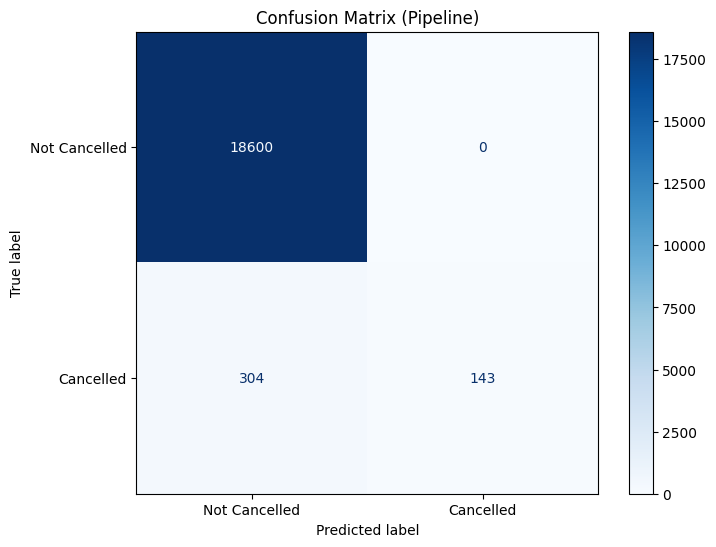

In [ ]:
# --- 6. Plotting ---
print("--- 6. Plotting Results ---")

# 6a. Confusion Matrix
if CAN_PLOT_CM:
    fig, ax = plt.subplots(figsize=(8, 6))
    ConfusionMatrixDisplay.from_estimator(
    model_pipeline, X_test, y_test, cmap='Blues', ax=ax,
    display_labels=['Not Cancelled', 'Cancelled']
    )
    plt.title('Confusion Matrix (Pipeline)')
    plt.show()
else:
    print("Skipping Confusion Matrix plot.")

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


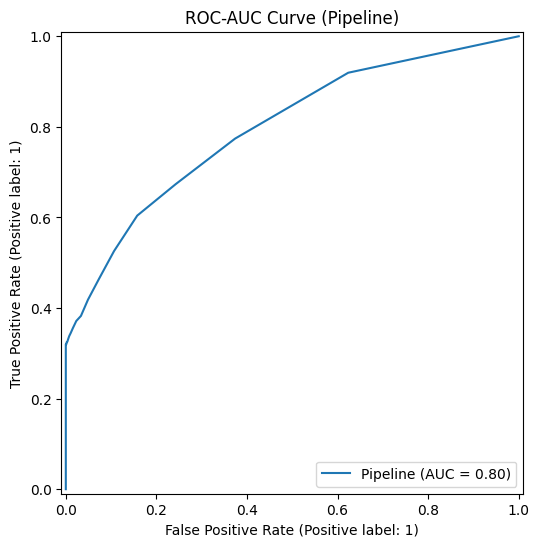

In [ ]:
# 6b. ROC Curve
if CAN_PLOT_ROC:
    fig, ax = plt.subplots(figsize=(8, 6))
    RocCurveDisplay.from_estimator(model_pipeline, X_test, y_test, ax=ax)
    plt.title('ROC-AUC Curve (Pipeline)')
    plt.show()
else:
    print("Skipping ROC-AUC plot.")

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


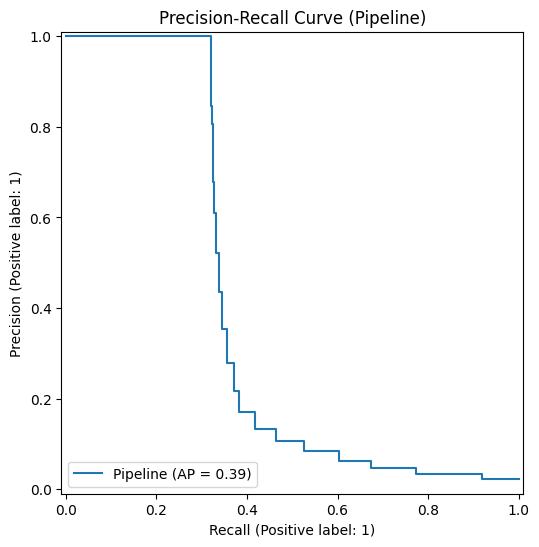

In [ ]:
# 6c. Precision-Recall Curve (NEW)
if CAN_PLOT_PR:
    fig, ax = plt.subplots(figsize=(8, 6))
    PrecisionRecallDisplay.from_estimator(model_pipeline, X_test, y_test, ax=ax)
    plt.title('Precision-Recall Curve (Pipeline)')
    plt.show()
else:
    print("Skipping Precision-Recall plot.")


Generating CAP Curve...


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


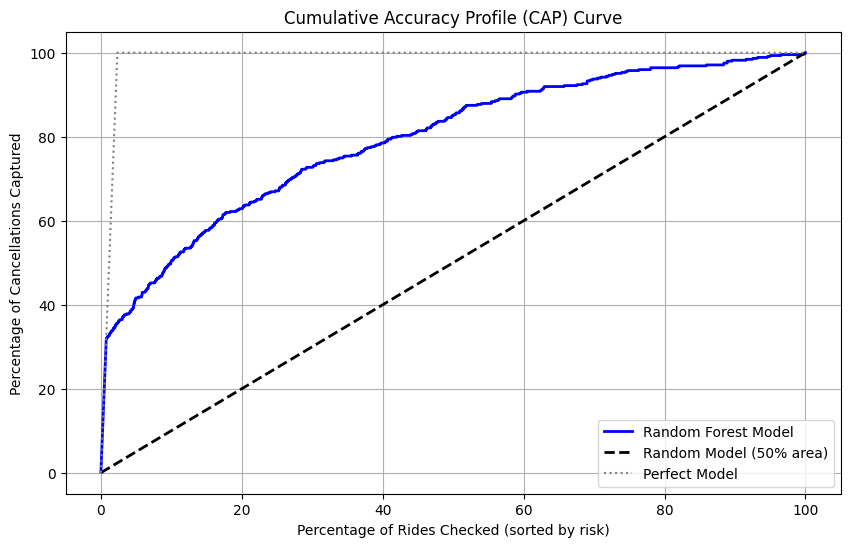

In [ ]:
# 6d. Cumulative Accuracy Profile (CAP) Curve (NEW - Custom Implementation)
print("\nGenerating CAP Curve...")
try:
    # 1. Get probabilities for the positive class (1)
    y_probs = model_pipeline.predict_proba(X_test)[:, 1]

    # 2. Create a dataframe for CAP analysis
    cap_df = pd.DataFrame({'y_true': y_test, 'y_prob': y_probs})

    # 3. Sort by probability (descending)
    cap_df = cap_df.sort_values(by='y_prob', ascending=False).reset_index(drop=True)

    # 4. Calculate cumulative positives
    total_positives = cap_df['y_true'].sum()
    total_samples = len(cap_df)

    # The 'Random Model' is a diagonal line from (0,0) to (100, 100)
    # The 'Perfect Model' captures all positives immediately

    # Cumulative Sum of actual positives found
    cap_df['cum_pos'] = cap_df['y_true'].cumsum()

    # X-axis: Percentage of samples checked
    x_values = np.arange(1, total_samples + 1) / total_samples * 100

    # Y-axis: Percentage of total positives captured
    y_values = cap_df['cum_pos'] / total_positives * 100

    # Plot
    plt.figure(figsize=(10, 6))

    # Plot the Model Curve
    plt.plot(x_values, y_values, marker='', color='blue', linewidth=2, label='Random Forest Model')

    # Plot Random Model (Diagonal)
    plt.plot([0, 100], [0, 100], 'k--', linewidth=2, label='Random Model (50% area)')

    # Plot Perfect Model (Grey dotted)
    # It goes straight up to 100% recall at (P/Total)% samples
    perc_positives = (total_positives / total_samples) * 100
    plt.plot([0, perc_positives, 100], [0, 100, 100], color='grey', linestyle=':', label='Perfect Model')

    plt.title('Cumulative Accuracy Profile (CAP) Curve')
    plt.xlabel('Percentage of Rides Checked (sorted by risk)')
    plt.ylabel('Percentage of Cancellations Captured')
    plt.legend()
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"Could not generate CAP Curve: {e}")

--- 7. Extracting Feature Importance ---


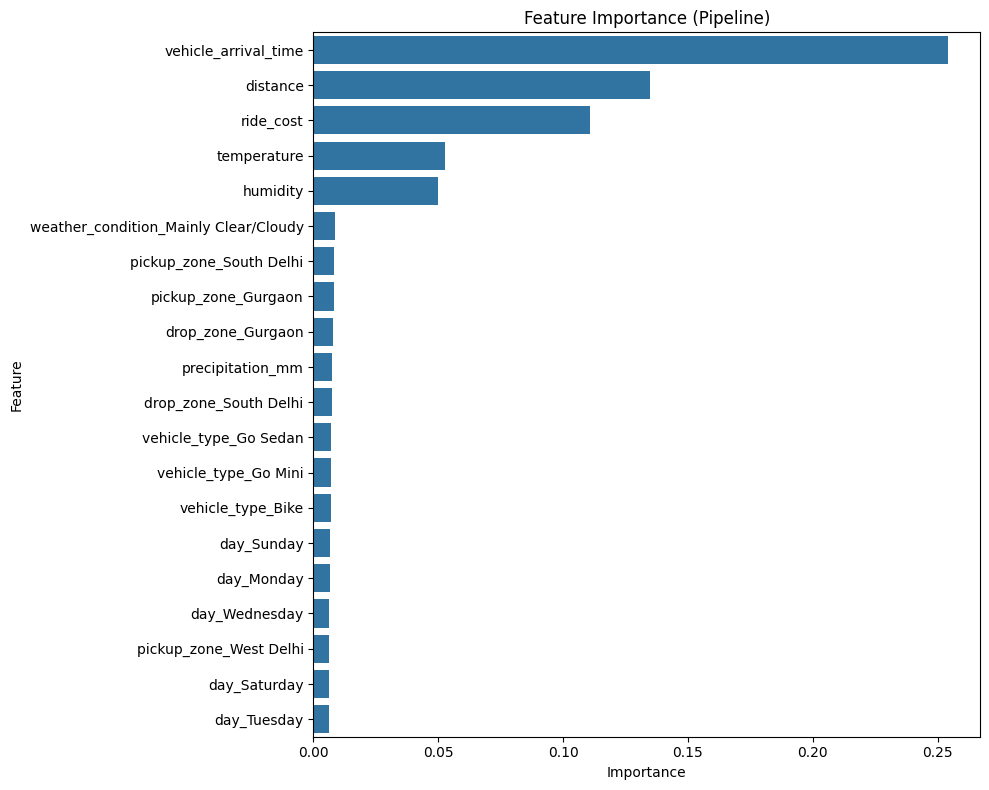

In [ ]:
# --- 7. Feature Importance Extraction ---
print("--- 7. Extracting Feature Importance ---")

try:
    fitted_preprocessor = model_pipeline.named_steps['preprocessor']

    # 1. Get numeric feature names
    feature_names = numerical_cols

    # 2. Get categorical feature names from OneHotEncoder
    ohe = fitted_preprocessor.named_transformers_['cat']['onehot']
    ohe_feature_names = list(ohe.get_feature_names_out(categorical_cols))

    # Combine
    all_feature_names = feature_names + ohe_feature_names

    # Get importances from the classifier step
    importances = model_pipeline.named_steps['classifier'].feature_importances_

    # Create DataFrame
    importance_df = pd.DataFrame({
        'Feature': all_feature_names,
        'Importance': importances
    })
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Plot
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title('Feature Importance (Pipeline)')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Could not extract feature importance names: {e}")

In [ ]:
# --- 8. SAVING THE PIPELINE ---
import joblib
try:
    filename = 'cancellation_model_pipeline.joblib'
    joblib.dump(model_pipeline, filename)
    print(f"\n--- SUCCESS: Model Pipeline saved to {filename} ---")
except Exception as e:
    print(f"\n--- ERROR: Could not save model. {e} ---")

print("\nPipeline script finished.")


--- SUCCESS: Model Pipeline saved to cancellation_model_pipeline.joblib ---

Pipeline script finished.
